<a href="https://colab.research.google.com/github/michaeledge27/CSCI290/blob/main/notebooks/cleanedKMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Means Method

In [81]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.ticker import FixedLocator, FixedFormatter

In [82]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [83]:
# return random sample of k initial centroids
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

In [84]:
# compare old centroids to new centroids to see if the algorithm has converged yet
# return true if new_centroids is equal to old_centroids, false otherwise
def check_new_centroids(old_centroids, new_centroids):
    if old_centroids.empty:
        return False  # Return False at start of loop
    common_columns = list(set(old_centroids.columns) & set(new_centroids.columns) & set(df.columns[:-1]))
    return np.allclose(old_centroids[common_columns].values, new_centroids[common_columns].values, atol=0.001)
    # return np.allclose(old_centroids[df.columns[:-1]].values, new_centroids[df.columns[:-1]].values, atol=0.001)

In [85]:
def update_centroids(df):
    return df.groupby("current_cluster").mean()[df.columns[:-1]]

In [86]:
# plot data and centroids for each iteration
def plot_clusters(df, centroids, iteration, x, y):
    plt.figure(figsize=(5, 3))

    # Plot each cluster
    sns.scatterplot(x, y, data = df, hue = "current_cluster");

    # Plot the centroids
    plt.scatter(
        centroids[x], centroids[y],
        color="red", marker="X", s=200, label="Centroids"
    )

    plt.title(f'Iteration {iteration}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    plt.pause(1)
    clear_output(wait=True)

In [87]:
def get_cluster(df, centroids, x=None, y=None, plot=True):
    # initialize old centroids as an empty dataframe
    old_centroids = pd.DataFrame()
    # keep track of what iteration we are on for plotting
    iteration = 0
    # run iteratively while the new centroids are different from the old ones
    while not check_new_centroids(old_centroids, centroids):
        # update the old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for _, centroid in centroids.iterrows():
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], centroid))
            # assign the point to the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            df.loc[i, 'current_cluster'] = closest_cluster

        if plot:
          # plot clusters and centroids
          plot_clusters(df, centroids, iteration, x, y)
        #update centroids
        centroids = update_centroids(df)
        iteration += 1
    return df


In [88]:
def calculate_accuracy(df, clustered_df, target):
    accuracy = 0
    for i in df.index:
        if df.loc[i, target] == clustered_df.loc[i, 'current_cluster']:
            accuracy += 1
    return accuracy / len(df)

In [89]:
def get_inertia(df, centroids):
    # initialize as 0
    inertia = 0
    # loop through each point
    for i in df.index:
        # get cluster assignment
        cluster = df.loc[i, 'current_cluster']
        # calculate euclidean distance between the point and its assigned centroid
        distance = euclidean_distance(df.loc[i, df.columns[:-1]], centroids.loc[cluster])
        # add the squared distance to the total inertia
        inertia += distance**2
    return inertia

In [90]:
def plot_intertia(df):
  inertias = []
  for i in range(1, 11):
      centroids = get_random_centroids(df, i)
      clustered_df = get_cluster(df, centroids, plot=False)
      inertia = get_inertia(clustered_df, update_centroids(clustered_df))
      inertias.append(inertia)


  plt.plot(range(1, 11), inertias, marker='o')
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.show()

In [91]:
def initialize_centroids(df, k):
    # initialize list to hold k centroids
    centroids = []
    # randomly select first centroid
    first_centroid = df.sample(1).iloc[0]
    # add it to the centroid list
    centroids.append(first_centroid)
    # get remaining k-1 centroids
    for i in range(1, k):     # k is exclusive
        # initialize list to hold distances from new centroids to the first centroid
        distances = []
        # loop through each point in the data frame
        for i in df.index:
            point = df.loc[i, df.columns[:-1]]
            # Calculate the distance from the current point to each centroid
            min_distance = min(euclidean_distance(point, centroid) for centroid in centroids)
            distances.append(min_distance**2)  # Append squared distance
        # compute probabilities
        probabilities = distances / np.sum(distances)
        # select new centroid
        new_centroid = df.sample(1, weights=probabilities).iloc[0]
        # add new centroid to list
        centroids.append(new_centroid)

    return pd.DataFrame(centroids, columns=df.columns[:-1])

In [92]:
# calculate mean inter cluster distance (a_i)
def mean_icd(df, point_index):
    distances = []
    # get the current cluster of the point
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all points in the current cluster
    cluster_points = df[df['current_cluster'] == current_cluster]
    # loop through all points in current cluster
    for i in cluster_points.index:
        # exclude the point itself
        if i != point_index:
            # calculate and append mean distance between the current point and all other points
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))

    return np.mean(distances) if distances else 0

In [93]:
# calculate mean nearest cluster distance (b_i)
def mean_ncd(df, point_index):
    total_distances = []
    # get the current cluster
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all other clusters
    other_clusters = df[df['current_cluster'] != current_cluster]
    # loop through each unique cluster in other_clusters
    for cluster in other_clusters['current_cluster'].unique():
        # get all points belonging to the cluster being considered
        cluster_points = df[df['current_cluster'] == cluster]
        # compute distance to all points in the current cluster
        distances = []
        for i in cluster_points.index:
            # calculate distance between this point and each point in the current cluster
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))
        # calculate mean distance to the current cluster
        total_distances.append(np.mean(distances))
    # return minimum mean distance among all clusters
    return min(total_distances)


In [94]:
def get_silhouette_coefficients(df):
    # get all points in the current cluster
    # df = df[df['current_cluster'] == cluster]
    # store coefficients for a cluster
    silhouette_coefficients = []
    # loop through each point in the cluster
    for i in df.index:
        # calculate mean inter cluster distance
        a = mean_icd(df, i)
        # calculate mean nearest cluster distance
        b = mean_ncd(df, i)
        # compute silhouette coefficient for each point
        silhouette_coefficients.append((b - a) / max(a, b))
    new_df = pd.DataFrame( { 'silhouette coefficient': silhouette_coefficients,
                                 'current_cluster': df['current_cluster'] } )
    # return silhouette coefficients for all points in the cluster
    return new_df

In [95]:
def silhouette_plots(df):
    for k in range(2, 6):
        plt.subplot(2, 2, k-1)
        centroids = initialize_centroids(df, k)
        clustered_df = get_cluster(df, centroids, plot=False)
        new_df = get_silhouette_coefficients(clustered_df)
        silhouette_score = np.mean(new_df['silhouette coefficient'])
        padding = len(new_df) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = new_df[new_df['current_cluster'] == i]['silhouette coefficient']
            coeffs = list(coeffs)
            coeffs.sort()
            color = plt.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        plt.ylabel("Cluster")

        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.axvline(x=silhouette_score, color="red", linestyle="--")
        plt.title(f"$k={k}$")

    plt.show()

# testing on iris

In [96]:
from sklearn.datasets import load_iris

In [97]:
iris = load_iris()

In [98]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


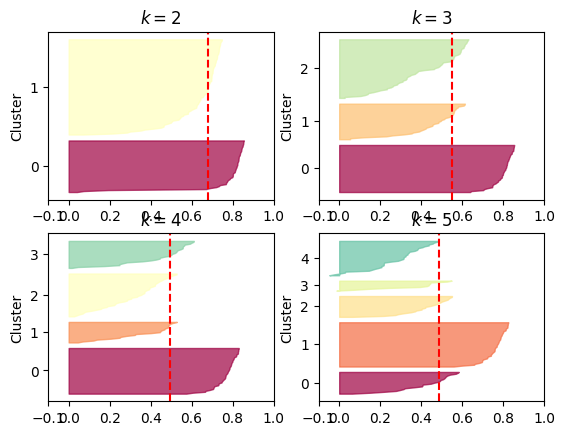

In [99]:
silhouette_plots(df)

# testing on penguins

In [62]:
df = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/penguins.csv")
df = df.dropna()
df.drop(columns=['island', 'sex', 'year', 'species'], inplace=True)
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
339,55.8,19.8,207.0,4000.0
340,43.5,18.1,202.0,3400.0
341,49.6,18.2,193.0,3775.0
342,50.8,19.0,210.0,4100.0


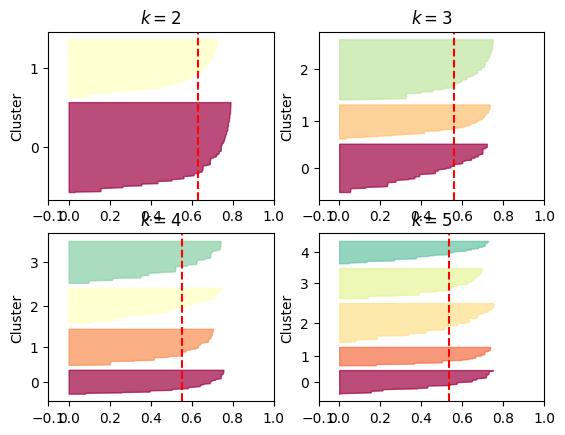

In [63]:
silhouette_plots(df)